# Principle Component Analysis

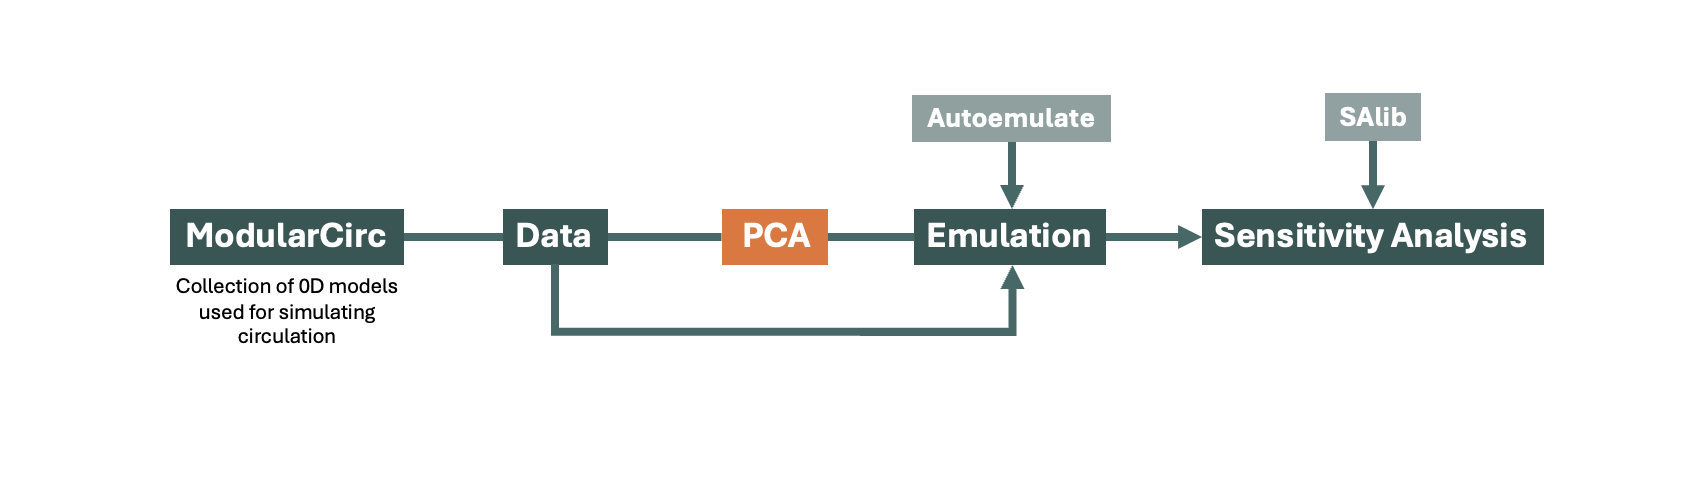

## After creating a dataset

### PCA

[Principal Component Analysis](https://www.kaggle.com/code/ryanholbrook/principal-component-analysis) (PCA) is a statistical technique used for dimensionality reduction in data. It transforms a large set of variables into a smaller one that still contains most of the information in the original set.

We are using PCA in this case to help with:
* Dimensionality reduction -  When some features are redundant, PCA can partition out the redundant features into near-zero variance components, which can then be dropped as they will contain limited information.

* Noise reduction - PCA can collect the relevant signal into a smaller number of features while leaving the noise alone - can be dropped.

Start by importing the necessary modules:


In [ ]:
%load_ext autoreload 
%autoreload 2

import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import os
import circ_utils

!pwd

Input the size of the dataset that you would like to use for PCA:

In [ ]:
n_runs = 2000
input_directory = f"./data/pressure_traces_{n_runs}"
input_directory

In [ ]:
main_path = os.getcwd()
main_path

In [ ]:
cardiac_data_df = circ_utils.simulation_loader(input_directory=input_directory)
cardiac_data_df.head()

In [ ]:
for _, row in cardiac_data_df.iterrows():
    plt.plot(row.values[:100])

plt.show()

#### Steps for PCA

* Run PCA with an initally high number of components - 10-20

* Fit scikit-learn's PCA estimator and create the principal components.

PCA is sensitive to scale. It's good to standardize the data before applying PCA.

In [ ]:
# Copy the data and separate the target variable
X = cardiac_data_df.copy()
# y = X.pop("C0 (mm^3/s)")
X = X.iloc[:, 0:102]

# Create an instance of StandardScaler
scaler = StandardScaler()
# Fit the scaler to the data and transform it - standardize
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X_scaled)

# Convert to dataframe
component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names, index=cardiac_data_df.index)

X_pca.head()

Histograms of the first 10 components:

In [ ]:
# Plot Histograms
X_pca.hist(bins=30, figsize=(15, 13), layout=(5, 2), alpha=0.7, color='orange')
plt.suptitle('Histograms of the First 10 Principal Components')
plt.show()

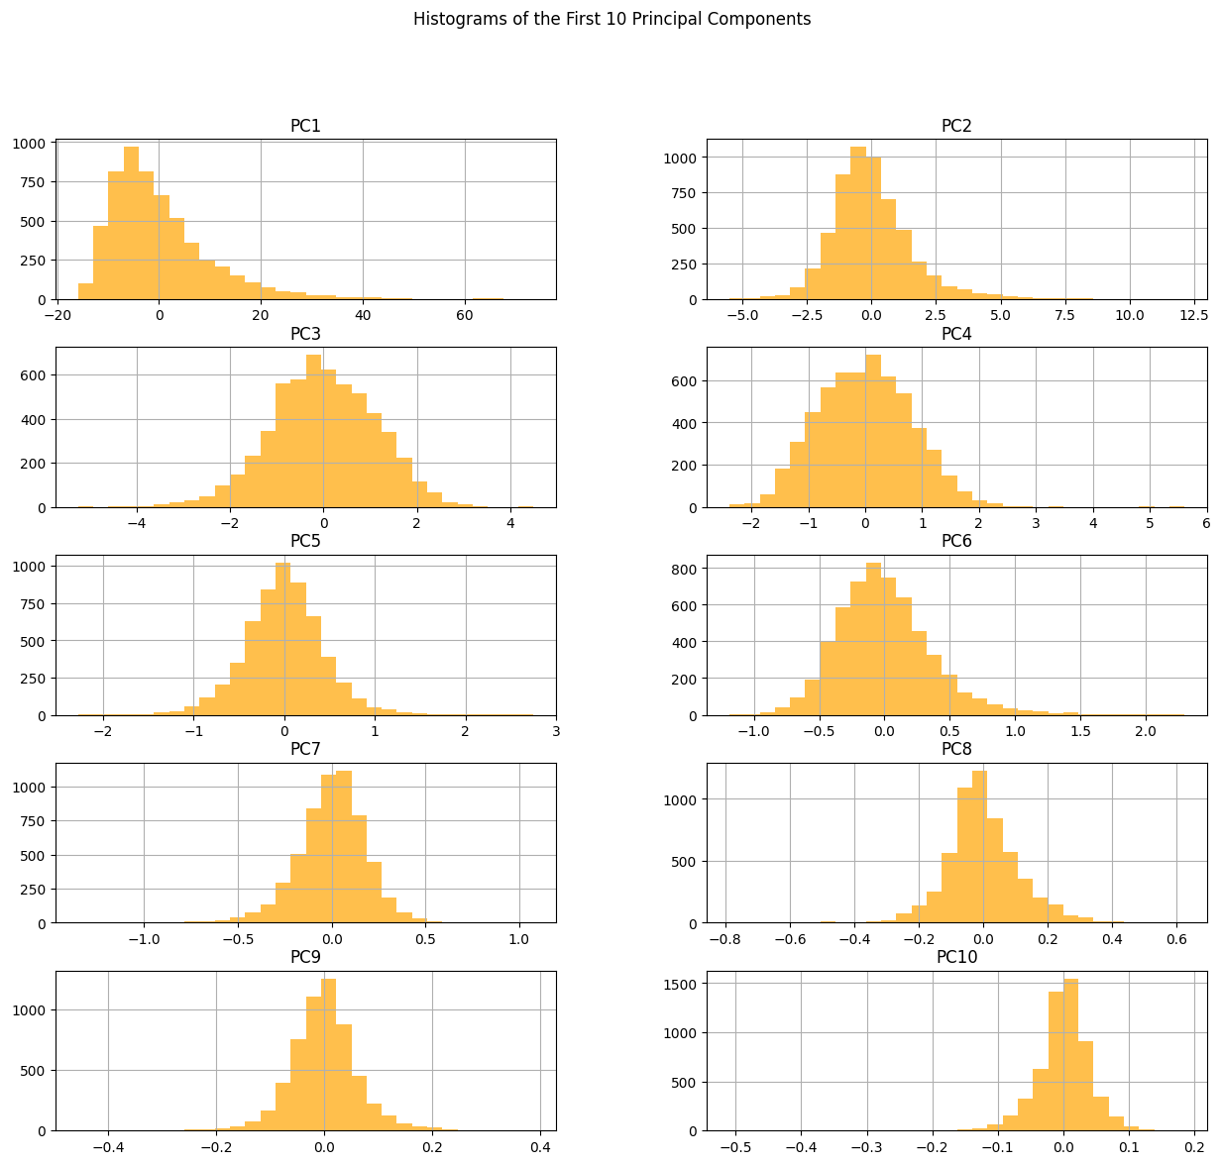

Plot the explained and cumulative variance - using function from circ_utils.

The proportion of the dataset's variance captured by each principal component can be analyzed to decide how many components to keep - in this case we aimed to retain 99% of variance in the data.

In [ ]:
circ_utils.plot_variance(pca)

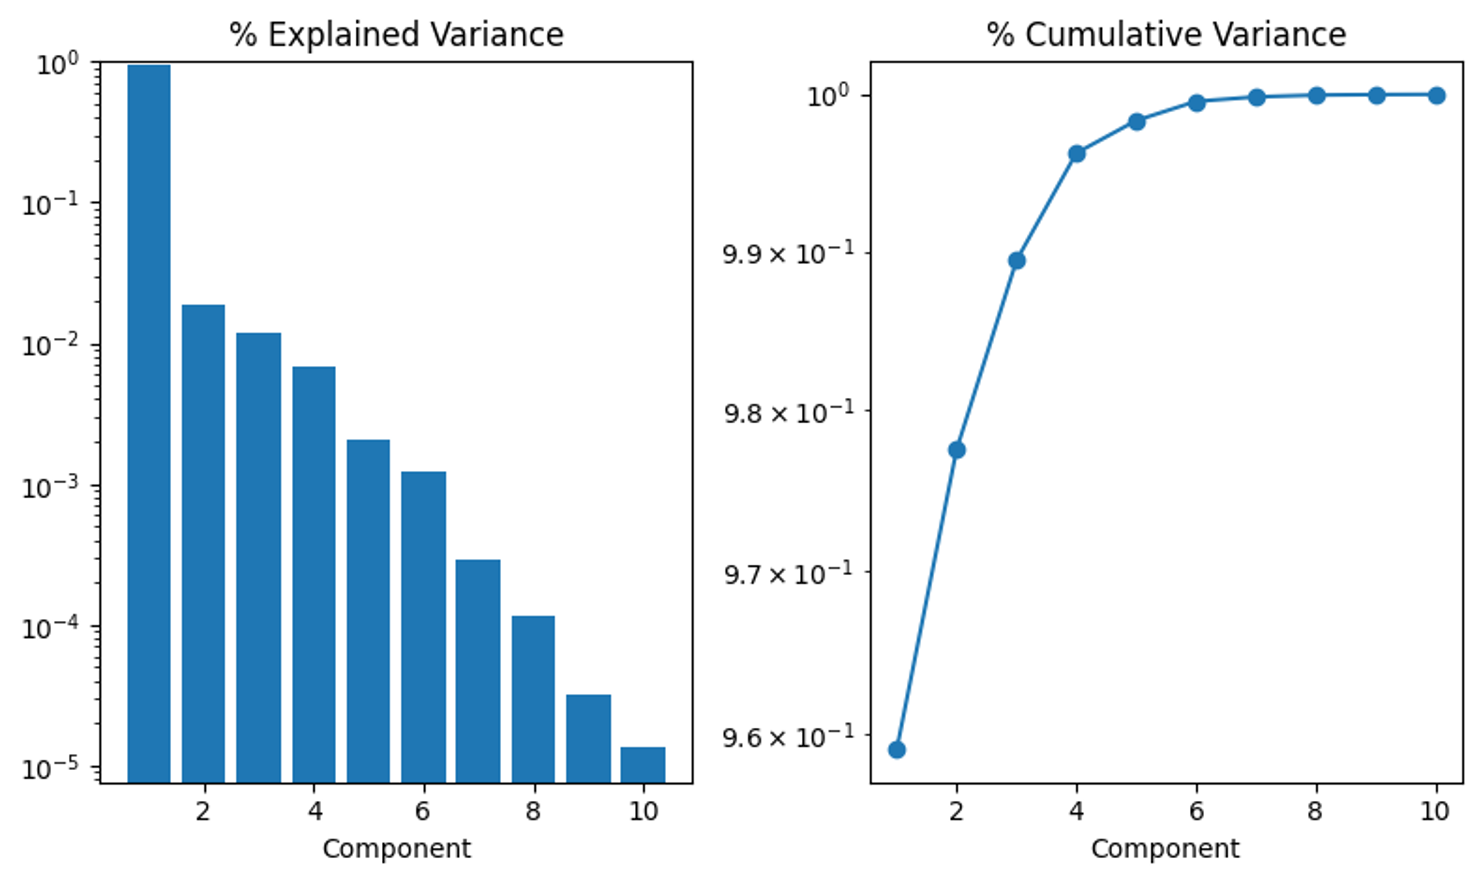

#### Plotting PCA components on separate graphs

PCA identifies axes called principal components that maximize variance in the data - these are linear combinations of the original variables and are uncorrelated to each other.

The first principal component captures the most variance, the second captures the second most with each following component capturing the next most variance.

Reducing data fewer dimensions can also make it easier to visualise complex datasets.

In [ ]:
fig, ax = plt.subplots(nrows=pca.n_components_, figsize=(5, 5*pca.n_components_))
for i in range(pca.n_components_):
    for row in circ_utils.get_component(X_scaled, pca.components_, i, scaler):
        ax[i].plot(row[:100])
        ax[i].set_title('Principle Component '+ str(i+1))

fig.tight_layout()
plt.show()

#### K Fold Cross Validation

In K fold:
* The training set is split into *k* smaller sets.

* A model is trained using *k-1* of the folds as training data.

* The resulting model is validated on the remaining part of the data.

https://scikit-learn.org/stable/modules/cross_validation.html

Run K Fold with the reduced number of Principle Components. Then look at variance, see if explained variance matches between folds (can take one as reference - and do relative % error).


* Split the data into training and test sets.

* Apply PCA on each training set.

* Calculate the mean and standard deviation of the explained variance ratios across folds to calculate the percentage error.

* Percentage error = (standard deviation / mean * 100).

* Checked that explained variance ratios matched across folds.

In [ ]:
kf = KFold(n_splits=5, random_state=1, shuffle=True)

explained_variance_ratios = []
pca_components = []

for train_index, test_index in kf.split(X_scaled):
    X_train, _ = X_scaled[train_index], X_scaled[test_index]
    
    pca = PCA(n_components=4)
    X_train_pca = pca.fit_transform(X_train)

    # Store the PCA components
    pca_components.append(pca.components_)
    # Store the explained variance ratio of this fold
    explained_variance_ratios.append(pca.explained_variance_ratio_)


explained_variance_ratios = np.array(explained_variance_ratios)

mean_explained_variance_ratio = np.mean(explained_variance_ratios, axis=0)
std_explained_variance_ratio = np.std(explained_variance_ratios, axis=0)

percentage_error = (std_explained_variance_ratio / mean_explained_variance_ratio) * 100
print(f'percentage error: \n{percentage_error}')
print(f'explained variance ratios: \n{explained_variance_ratios}')


#### Retraining PCA
* Retrain the model on all the data with the new set of components.

* Save scaler and PCA to a file.

In [ ]:
pca_reduce = PCA(n_components=4)
pca_reduced = pca_reduce.fit_transform(X_scaled)

component_names = [f"PC{i+1}" for i in range(pca_reduced.shape[1])]
pca_reduced = pd.DataFrame(pca_reduced, columns=component_names, index=cardiac_data_df.index)

In [ ]:
os.system(f'mkdir -p {main_path}/data/output_pca_{n_runs}')
joblib.dump(scaler, f'./data/output_pca_{n_runs}/scaler.pkl')
joblib.dump(pca_reduced, f'./data/output_pca_{n_runs}/pca.pkl')